# Setup

In [ ]:
%pip install magtrack matplotlib

In [1]:
import magtrack
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

In [2]:
# Verify a GPU exists
try:
  cp.cuda.runtime.getDeviceCount()
except Exception:
  print('Error! '*10 + '\n')
  print("No GPU runtime.\n")
  print("In Colab: Runtime → Change runtime type → GPU. \n\n")
else:
  dev = cp.cuda.runtime.getDevice()
  props = cp.cuda.runtime.getDeviceProperties(dev)
  name = props["name"].decode() if isinstance(props["name"], (bytes, bytearray)) else props["name"]
  print(f"GPU: {name} | CC {props['major']}.{props['minor']} | {props['totalGlobalMem']/1e9:.1f} GB")

GPU: NVIDIA GeForce RTX 3070 | CC 8.6 | 8.6 GB


# Example 1: Get XY with Center-of-Mass with CPU

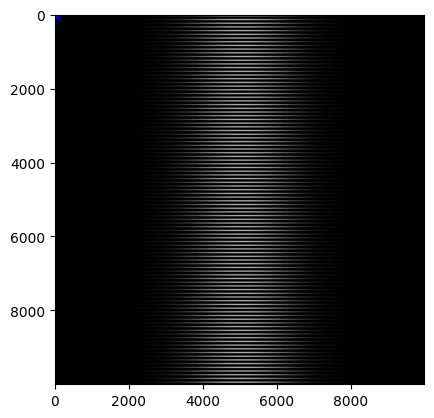

In [21]:
roi = 100
X, Y = np.meshgrid(np.arange(roi), np.arange(roi))
X = X.flatten().astype('float')
Y = Y.flatten().astype('float')
mu_x = np.array([roi/2])
mu_y = np.array([roi/2])
sigma = np.array([roi/10])
image_stack = magtrack.gaussian_2d(X, Y, mu_x, mu_y, sigma)

plt.imshow(img, cmap='gray')
plt.plot(mu_x, mu_y, 'bx', label='True')
plt.show()

In [3]:
x, y = magtrack.center_of_mass(image_stack)
print(f'x: {x}, y: {y}')

x: [nan], y: [nan]


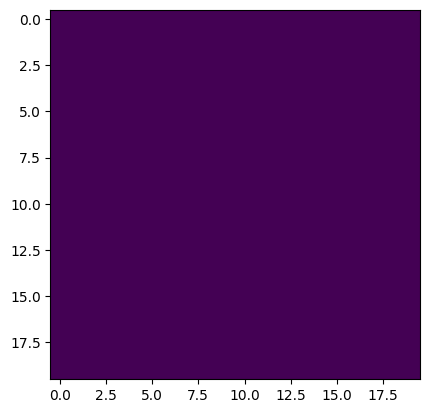

In [4]:
plt.imshow(image_stack[:, :, 0])
plt.plot(x, y, 'r+')
plt.show()

# Example 2: Get XY with Center-of-Mass with GPU

In [7]:
image_stack_gpu = cp.asarray(image_stack)
x_gpu, y_gpu = magtrack.center_of_mass(image_stack_gpu)
x_gpu, y_gpu = cp.asnumpy(x_gpu), cp.asnumpy(y_gpu)
print(f'x: {x_gpu}, y: {y_gpu}')

x: [nan], y: [nan]


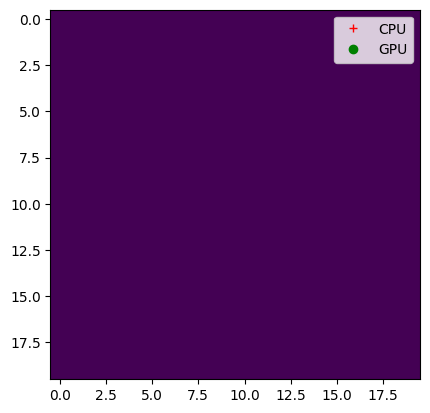

In [8]:
plt.imshow(image_stack[:, :, 0])
plt.plot(x, y, 'r+', label='CPU')
plt.plot(x_gpu, y_gpu, 'go', label='GPU')
plt.legend()
plt.show()